In [12]:
using Rocket
using ReactiveMP
using GraphPPL
using BenchmarkTools
using Distributions
using MacroTools
using LinearAlgebra
using Plots

In [14]:
@model [ default_factorisation = MeanField() ] function hidden_markov_model(n)
    
    A ~ MatrixDirichlet(ones(3, 3))
    B ~ MatrixDirichlet([ 10.0 1.0 1.0; 1.0 10.0 1.0; 1.0 1.0 10.0 ])
    
    s_0 ~ Categorical(fill(1.0 / 3.0, 3))
    
    s = randomvar(n)
    x = datavar(Vector{Float64}, n)
    
    s_prev = s_0
    
    for t in 1:n
        s[t] ~ Transition(s_prev, A) where { q = q(out, in)q(a) }
        x[t] ~ Transition(s[t], B)
        s_prev = s[t]
    end
    
    return s, x, A, B
end

LoadError: LoadError: [91m123[39m
in expression starting at In[14]:1

In [3]:
function inference(data, n_its)
    n = length(data)
    
    model, (s, x, A, B) = hidden_markov_model(n, options = (limit_stack_depth = 500, ))
    
    sbuffer = keep(Vector{Marginal})
    Abuffer = keep(Marginal)
    Bbuffer = keep(Marginal)
    fe      = ScoreActor(Float64)
    
    fe_scheduler = PendingScheduler()

    ssub  = subscribe!(getmarginals(s), sbuffer)
    Asub  = subscribe!(getmarginal(A), Abuffer)
    Bsub  = subscribe!(getmarginal(B), Bbuffer)
    fesub = subscribe!(score(Float64, BetheFreeEnergy(), model), fe)
    
    # Initial marginals for VMP
    setmarginal!(A, vague(MatrixDirichlet, 3, 3))
    setmarginal!(B, vague(MatrixDirichlet, 3, 3))

    for i in 1:n_its
        update!(x, data)
        release!(fe_scheduler)
    end
    
    unsubscribe!(ssub)
    unsubscribe!(Asub)
    unsubscribe!(Bsub)
    unsubscribe!(fesub)
    
    return map(getvalues, (sbuffer, Abuffer, Bbuffer, fe))
end

inference (generic function with 1 method)

In [4]:
using Random

function rand_vec(distribution::Categorical) 
    k = ncategories(distribution)
    s = zeros(k)
    s[ rand(distribution) ] = 1.0
    s
end

function generate_data(n_samples; seed = 124)
    Random.seed!(seed)
    
    # Transition probabilities (some transitions are impossible)
    A = [0.9 0.0 0.1; 0.1 0.9 0.0; 0.0 0.1 0.9] 
    # Observation noise
    B = [0.9 0.05 0.05; 0.05 0.9 0.05; 0.05 0.05 0.9] 
    # Initial state
    s_0 = [1.0, 0.0, 0.0] 
    # Generate some data
    s = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the states
    x = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the observations
    
    s_prev = s_0
    
    for t = 1:n_samples
        a = A * s_prev
        s[t] = rand_vec(Categorical(a ./ sum(a)))
        b = B * s[t]
        x[t] = rand_vec(Categorical(b ./ sum(b)))
        s_prev = s[t]
    end
    
    return x, s
end

generate_data (generic function with 1 method)

In [5]:
x, s = generate_data(100);

In [6]:
s_est, A_est, B_est, fe = inference(x, 40);

In [7]:
mean(A_est[end])

3×3 Array{Float64,2}:
 0.892972   0.0829833  0.13378
 0.0858227  0.69125    0.042772
 0.0212053  0.225766   0.823448

In [8]:
mean(B_est[end])

3×3 Array{Float64,2}:
 0.908102   0.0422189  0.0718204
 0.0695278  0.882202   0.0430434
 0.0223703  0.075579   0.885136

In [9]:
fe

40-element Array{Float64,1}:
 132.1980515620985
 125.34416353806728
 120.53326593251518
 113.41617548749196
  99.32381143981524
  84.93198693499016
  80.64759255738454
  79.6207275794959
  79.16619379819804
  78.93663311731189
  78.83165917861106
  78.78936503729892
  78.77393378534043
   ⋮
  78.76605161986845
  78.76605161872749
  78.76605161815951
  78.76605161787256
  78.76605161772659
  78.76605161765156
  78.76605161761245
  78.76605161759335
  78.76605161758289
  78.76605161757834
  78.76605161757561
  78.7660516175747

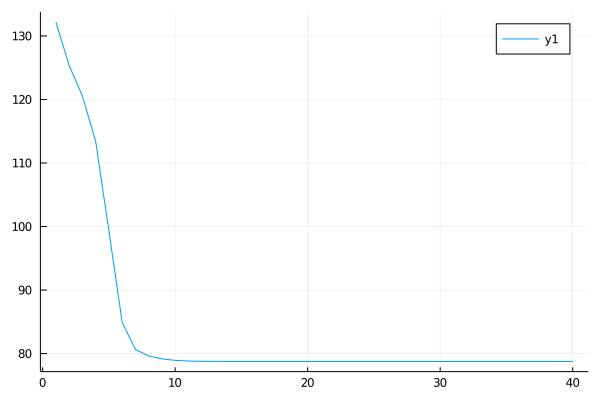

In [10]:
plot(fe)

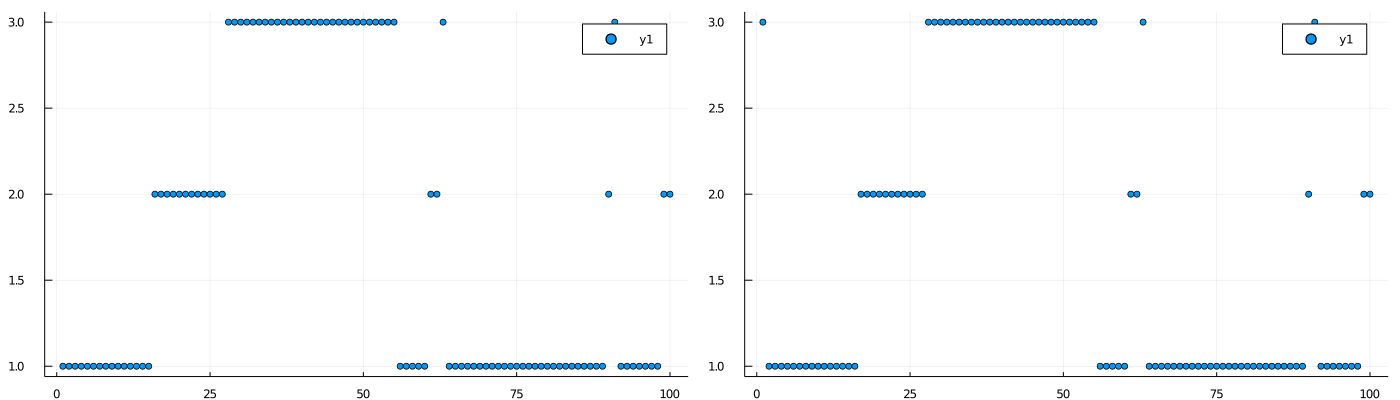

In [11]:
using Plots

p1 = scatter(argmax.(s))
p2 = scatter(argmax.(ReactiveMP.probvec.(s_est[end])))

plot(p1, p2, size = (1400, 400))